In [2]:
from matplotlib.transforms import offset_copy
import numpy as np
import h5py as h5py
import math as math
import matplotlib.pyplot as plt
%matplotlib widget

hdf5_file = h5py.File("./test.hdf5", "r")
datef = np.array(hdf5_file.get("date"))
eastposf = np.array(hdf5_file.get("eastpos"))
northposf = np.array(hdf5_file.get("northpos"))
offset = np.array(hdf5_file.get("offs"))
lat = np.array(hdf5_file.get("lat"))
lon = np.array(hdf5_file.get("lon"))

ns = np.size(datef, 0)
nd = np.size(datef, 1)

def dailyslopes(pos):

    datef = np.array(hdf5_file.get("date"))
    offset = np.array(hdf5_file.get("offs"))

    nzdates = datef > 0

    offset = np.transpose(offset)
    slopes = np.zeros((ns,nd))
    ltslope = np.zeros((ns,nd))

    stations = np.where((lat > 34.5) & (lat < 37.5) & (lon > 139.5) & (lon < 141.5))[0]
    
    for i in stations:
        keep = nzdates[i,:]
        keepdates = datef[i,keep]

        wslopemat = np.transpose(np.array([((keepdates)), (np.ones(sum(keep))), ((np.sin((np.multiply((keepdates),2*math.pi/365.25))))), ((np.cos((np.multiply((keepdates),2*math.pi/365.25))))), ((np.sin((np.multiply((keepdates),2*math.pi/(365.25/2)))))), ((np.cos((np.multiply((keepdates),2*math.pi/(365.25/2)))))), ((np.sin((np.multiply((keepdates),2*math.pi/13.6608))))), ((np.cos((np.multiply((keepdates),2*math.pi/13.6608))))), ((np.sin((np.multiply((keepdates),2*math.pi/14.7653))))), ((np.cos((np.multiply((keepdates),2*math.pi/14.7653))))), ((np.sin((np.multiply((keepdates),2*math.pi/27.5546))))), ((np.cos((np.multiply((keepdates),2*math.pi/27.5546))))), ((np.sin((np.multiply((keepdates),2*math.pi/6793.65))))), ((np.cos((np.multiply((keepdates),2*math.pi/6793.65)))))]))
    
    # fig,ax = plt.subplots()
    # ax.plot(datef[i,keep], pos[i,keep])
    # plt.show()

        postseismic = np.zeros((keepdates.shape[0],1))
        eqidx = np.where(keepdates>=734573)
        postseismic[eqidx,0] = .9995 ** (keepdates[eqidx]-734573)

        numoffs = int(max(offset[:,i]))
        offsetcol = offset[keep,i]
        offsetmatrix = np.zeros((len(offsetcol),numoffs))
        if len(offsetcol) > 0 and numoffs > 0:
            for j in range(len(offsetcol)):
                offsetmatrix[j,0] = offsetcol[j]

        for j in range (0,numoffs):
            for k in range(0,len(offsetcol)):
                if offsetmatrix[k,j] > 1:
                    offsetmatrix[k,j+1] = offsetmatrix[k,j] - 1
                    offsetmatrix[k,j] = 1

        zerocolidx = np.array([])
        for j in range (0, offsetmatrix.shape[1]):
            if np.sum(offsetmatrix[j]) == 0:
                zerocolidx = np.append(zerocolidx, j)
        for j in range(len(zerocolidx), 0):
            offsetmatrix = np.delete(offsetmatrix, zerocolidx[j], axis = 1)

        wslopemat = np.concatenate((wslopemat, offsetmatrix), axis = 1)
        # wslopemat = np.hstack((wslopemat, postseismic))
        # wslopemat = np.unique(wslopemat, axis = 1) # makes matrix out of order    

        lt_modelparam = np.linalg.lstsq(wslopemat, pos[i,keep], rcond=None)[0]
        ltslope[i] = lt_modelparam[0]

        pred = wslopemat[:,2:] @ lt_modelparam[2:]

        pos[i,keep] = pos[i,keep] - pred

        windowlength = 20
        timev = np.column_stack((np.array(range(0,windowlength + 1)), np.ones(windowlength + 1)))
        slope = np.zeros((windowlength+1))
        for j in range ((windowlength), (np.argmax(datef[i,:])+1 - windowlength)):
            for k in range (0, windowlength + 1):
                positions = pos[i, j + (k-windowlength) : j + k + 1]
                nzpos = positions != 0
                if np.sum(nzpos) > windowlength/2:
                    slope[k] = np.linalg.lstsq(timev[nzpos, :], positions[nzpos], rcond=None)[0][0]
            nzslope = slope != 0
            if np.sum(nzslope) > windowlength/2:
                slopes[i,j] = np.mean(slope[np.nonzero(slope)], axis = 0)
    return slopes, ltslope


In [7]:
eastposf_copy = np.copy(eastposf)
northposf_copy = np.copy(northposf)

slopese, ltslopee = dailyslopes(eastposf_copy)
slopesn, ltslopen = dailyslopes(northposf_copy)

In [3]:
# only calculated for boso stations
slopese = np.genfromtxt("bosoeslopes.csv", delimiter = ",")
slopesn = np.genfromtxt("bosonslopes.csv", delimiter = ",")
ltslopee = np.genfromtxt("bosoeltslope.csv", delimiter = ",")
ltslopen = np.genfromtxt("bosonltslope.csv", delimiter = ",")

In [36]:
ltangle = (180 / np.pi) * np.arctan2(ltslopen, ltslopee)

angle = np.zeros((ns, nd))

angdiff = np.zeros((ns, nd))
for i in range(99,105):
    for j in range(0,nd):
        if slopesn[i,j] != 0 and slopese[i,j] != 0:
             angle[i,j] = (180 / np.pi) * np.arctan2(slopesn[i,j], slopese[i,j])    
        if angle[i,j] != 0:
            if angle[i,j] * ltangle[i,j] > 0:
                angdiff[i,j] = abs(angle[i,j] - ltangle[i,j])
            elif abs(angle[i,j] - ltangle[i,j]) <= 180:
                angdiff[i,j] = abs(angle[i,j]) + abs(ltangle[i,j])
            elif abs(angle[i,j] - ltangle[i,j]) > 180:
                angdiff[i,j] = (180 - abs(angle[i,j])) + 180 - (abs(ltangle[i,j]))
            else:
                print("problem")

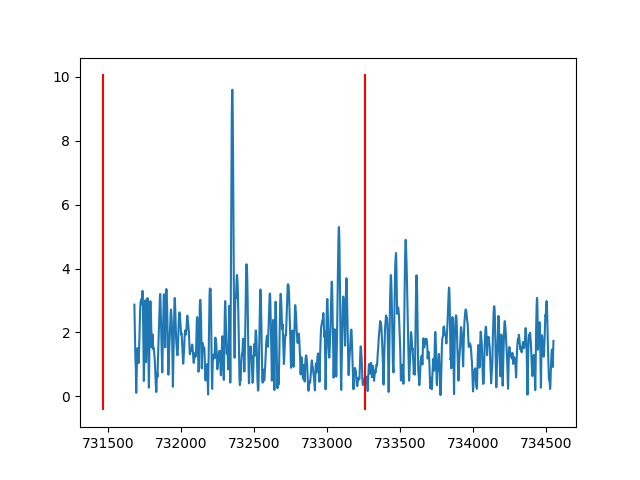

In [54]:
plt.close("all")
row = 6 # out of all rows, not just 
stations = np.where((lat > 34.5) & (lat < 37.5) & (lon > 139.5) & (lon < 141.5))[0]

eq = np.where(datef == 734550)[1][0]
start = np.where(datef == 731350)[1][0]
beforeeq = datef[:, start:eq]
bosobefeq = beforeeq[stations]
bosoeposbefeq = eastposf[stations, start:eq]
bosoeslopebefeq = slopese[stations, start:eq]
bosonposbefeq = northposf[stations, start:eq]
bosonslopebefeq = slopesn[stations, start:eq]

slopese_mean = np.mean(bosoeslopebefeq)
slopese_std = np.std(bosoeslopebefeq)
slopesn_mean = np.mean(bosonslopebefeq)
slopesn_std = np.std(bosonslopebefeq)

ecolor = np.zeros((np.size(bosoeslopebefeq,0), np.size(bosoeslopebefeq,1)))
ncolor = np.zeros((np.size(bosonslopebefeq,0), np.size(bosonslopebefeq,1)))

for i in range(0, np.size(bosoeslopebefeq,0)):
    for j in range (0, np.size(bosoeslopebefeq,1)):
        if bosoeslopebefeq[i,j] != 0:
            ecolor[i,j] = (bosoeslopebefeq[i,j] - slopese_mean) / slopese_std
        if bosonslopebefeq[i,j] != 0:
            ncolor[i,j] = (bosonslopebefeq[i,j] - slopesn_mean) / slopesn_std

fig,ax = plt.subplots()
ax.plot(bosobefeq[row, bosobefeq[row, :] != 0], abs(ecolor[row, bosobefeq[row, :] != 0])+abs(ncolor[row, bosobefeq[row, :] != 0]))
ylims = ax.get_ylim()
ax.vlines([731460, 733255], ylims[0], ylims[1], color = "red")
plt.show()

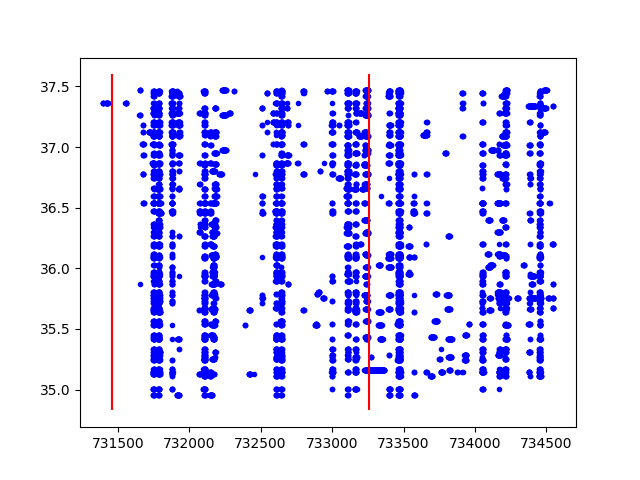

In [57]:
percentile = 95
combined = np.zeros((np.size(stations), np.size(bosoeslopebefeq,1)))
threshold = np.zeros((np.size(stations),np.size(bosoeslopebefeq,1)))
bosolat = lat[stations]

for i in range(0, np.size(bosoeslopebefeq,0)):
    slopese_mean = np.mean(bosoeslopebefeq[i])
    slopese_std = np.std(bosoeslopebefeq[i])
    slopesn_mean = np.mean(bosonslopebefeq[i])
    slopesn_std = np.std(bosonslopebefeq[i])

    for j in range(0, np.size(bosoeslopebefeq,1)):
        if bosoeslopebefeq[i,j] != 0:
            combined[i,j] = ((bosoeslopebefeq[i,j] - slopese_mean) / slopese_std) + ((bosonslopebefeq[i,j] - slopesn_mean) / slopesn_std)

threshold = np.percentile(combined, percentile, axis = 1)
thresholds = np.zeros((np.size(combined, 0), np.size(combined, 1)))
for i in range(0,(np.size(combined, 0))):
    for j in range(0,(np.size(combined, 1))):
        thresholds[i,j] = threshold[i]

is_sse = combined > thresholds

fig,ax = plt.subplots()
for i in range(np.size(bosoeslopebefeq, 0)):
    for j in range(np.size(bosoeslopebefeq, 1)):
        if is_sse[i,j] and beforeeq[i,j] > 0:
            ax.plot(beforeeq[i,j], bosolat[i][0], '.', color = "blue")
ylims = ax.get_ylim()
ax.vlines([731460, 733255], ylims[0], ylims[1], color = "red")
plt.show()